# Setting up PySpark enviornment

In [1]:
from pyspark import SparkContext
sc = SparkContext()

In [2]:
from pyspark import SQLContext
sqlContext = SQLContext(sc)

In [3]:
from pyspark.sql.functions import *
from pyspark.sql.types import * 

# Loading from HDFS  

Now that the PySpark enviornment has been setup, the next step is to load in the data from Hadoop. Dataframes can be loaded using PySpark in a fashion that is similar to pandas. The variable `inferSchema` tells PySpark  to guess what the datatype of each column in the dataframe is. If the option is set to ```False``` then all columns will be loaded in as strings. We'll start with 2014 green taxi trips.

In [4]:
green_2014 = sqlContext.read.csv("hdfs://namenode:8020/am2786/***/Taxi_2014_green.csv", header=True,inferSchema=True)

The format for timestamps in the green taxi datastamps is set up in a format taht PySpark can't propperly interpret. I deal with this later in the noteboook, but for now I'm making another column whcih will preserve the original string format of datetime columns in the green taxi dataset 

In [13]:
green_2014 = green_2014.withColumn('pickup_datetime_str', col("pickup_datetime"))

In [5]:
yellow_2014 = sqlContext.read.csv("hdfs://namenode:8020/am2786/***/Taxi_2014_yellow.csv", header=True,inferSchema=True)

### Cleaning data and assigning columns to proper data types

Since the data has been loaded, the next step is to convert the data type of columns in the database to the right data types. When we ask PySpark to infer the schema of the columns within a dataframe, we're essentially asking it "What datatype does the format of this column resemble?" If does not resemble anythiing then it will be left as a string. This is what is occuring with some of the columns within the dataframes. The most troublesome one is the `pickup_datetime` feature in the green taxis dataframe. The format of these times is a such: `2014-01-23 06:39:00 PM`. PySpark only recognizes what we in the states call "military time" (24-hour clock). We'll have to fix this at a later time, but for now what we'll do is create a duplicate column of `pickup_datetime` called `pickup_datetime_str`. 



In [7]:
# Write a custom function to convert the data type of DataFrame columns
def convertColumn(df, names, newType):
    for name in names: 
        df = df.withColumn(name, df[name].cast(newType))
    return df 

In [14]:
# Assign all column names to `columns`
columns = ['Tip_amount', 'Total_amount', 'Trip_distance', 'Fare_amount']

# Convert the `df` columns to `FloatType()`
green_2014_cleaned = convertColumn(green_2014, columns, FloatType())
yellow_2014_cleaned = convertColumn(yellow_2014, columns, FloatType())

In [15]:
# Convert the `df` columns to `IntegerType ()`
green_2014_cleaned = convertColumn(green_2014_cleaned, ['Passenger_count', 'Payment_type'], IntegerType())
yellow_2014_cleaned = convertColumn(yellow_2014_cleaned, ['Passenger_count'], IntegerType())

To convert our dates, PySpark does have a `DateType()` data type similar to IntegerType() and FloatType() however, using this method to convert datetime objects in PySpark can be unreliable and often results in a columns full null values. The most dependable method is re-create the columns with a specified data type and format, as in the cell below. The built in function `to_timestamp` converts strings to DateType() with the given specific format.

In [16]:
# Convert the df columns to datetime()
from pyspark.sql.functions import to_timestamp
green_2014_cleaned = green_2014_cleaned.withColumn("pickup_datetime", to_timestamp(green_2014_cleaned.pickup_datetime, 'MM/dd/yyyy HH:mm:ss'))
green_2014_cleaned = green_2014_cleaned.withColumn("dropoff_datetime", to_timestamp(green_2014_cleaned.dropoff_datetime, 'MM/dd/yyyy HH:mm:ss'))
yellow_2014_cleaned = yellow_2014_cleaned.withColumn("pickup_datetime", to_timestamp(yellow_2014_cleaned.pickup_datetime))
yellow_2014_cleaned = yellow_2014_cleaned.withColumn("dropoff_datetime", to_timestamp(yellow_2014_cleaned.dropoff_datetime))


#### Outlier and Incorrect Data Entry Detection

With any *real* dataset you can bet your last dollar that there will be some data that has been input incorrectly. In the case of our taxi data, this can be:

- Recording the incorrect number of passengers
- Error with the taxi meter that puts an impossibly *low* or *high* fare

Our safest course of action is to get rid of these incorrect taxi trips. In the case of the first issue pertaining to the number of passengers, we can get rid of any trips that have 0 passengers recorded, as this is impossible. For the fare amount we can set some minimum threshold for the fare amount where any trip with a fare less than that is thrown away. Doing a quick Google search reveals that taxis in New York have a $2.50 minimum, meaning that as soon as you step in that is what you are charged. We can use this as our minimum fare threshold. 

In [22]:
def taxi_data_cleaner(data):
    
    # Getting rid of rides with 0 passengers
    data = data.filter(data.Passenger_count > 0)
    
    # Getting rid of rides with impossibly low fares
    data = data.filter(data.Fare_amount > 1.)
    
    #Making a feature which measures the % a driver was tipped 
    data = data.withColumn("Tip_percentage", 100.*(col("Tip_amount")/(col("Total_amount") - col("Tip_amount"))))
    
    # Adding columns that give the month , day of the week and hour of pickups and dropoffs
    data = data.withColumn("pickup_dayofweek", date_format('pickup_datetime', 'u'))
    data = data.withColumn("dropoff_dayofweek", date_format('dropoff_datetime', 'u'))
    data = data.withColumn("pickup_month", month('pickup_datetime'))
    data = data.withColumn("dropoff_month", month('dropoff_datetime'))
    data = data.withColumn("pickup_hour", hour('pickup_datetime'))
    data = data.withColumn("dropoff_hour", hour('dropoff_datetime'))
    return(data)

In [17]:
green_2014_cleaned   =taxi_data_cleaner(green_2014_cleaned)
yellow_2014_cleaned  = taxi_data_cleaner(yellow_2014_cleaned)


For datetimes with 'AM' and 'PM' at the end PySPark will record the hour of that datetime as 6 as opposed to 18. To remedy this we can do the following:

1. Record if the the last 2 entries inthe datetime string for green taxi trips day 'Am' or 'PM'
2. Create a column which maps 'AM' values to the number 0 and PM values to the number 12.  
3. Add this new column to the old column `pickup_hour`

This will produce the correct results where pxikupis that occured in the PM will have an extra 12 hours added to their pickup hour. We begin with step 1.

In [18]:
# Mapping AM and PM values so that PM hours are taken into consideration
from pyspark.sql.functions import substring

# creating column which indicates if a trip occured during AM or PM hours
green_2014_cleaned = green_2014_cleaned.withColumn("AM/PM", substring(col("pickup_datetime_str"), 21, 2))


# Mapping all trips with AM values to an offset of 0 and all trips with PM values to an offset of 12
def translate(mapping):
    def translate_(col):
        return mapping.get(col)
    return udf(translate_, StringType())

AM_PM_map = dict( zip(['AM', 'PM'], [0, 12]))


# Adding column of which tracks the offset hours (0 for AM trips and 12 for PM trips)
green_2014_cleaned = green_2014_cleaned.withColumn("hour_offset", translate(AM_PM_map)("AM/PM"))

# Changing `pickup_hour` column to correct hour by adding `hour_offset` to `pickup_hour`
green_2014_cleaned = green_2014_cleaned.withColumn("pickup_hour", col("pickup_hour") + col("hour_offset"))



Now we can look at how the number of trips changing depending on the time of the day. Presumably, this distribution would differ on weeekdays when everyone is working vs. weekends when people are going out to events and parties.

To begin we need to group the number of taxi trips by the hour at which they occured. Rmember in the beginning of this notebook, when I stated that the format of of pickup and dropoff datetime columns for green taxis would be a problem? I'll give you a efresher, just in case. Unlike the yellow taxi data, datetimes for green taxi are recorded in AM/PM formae (i.e. ). PySPark can't properly interpret this format, and to illustrate this I'll group both the yellow and green taxi dataframes by the column `pickup_hour`. We created this column earlier and it was meant to track the hour of the day at which each taxi trip started.

In [19]:
# Creating dataframes which only contain trips that occured on weekdays
green_2014_cleaned_weekdays   = green_2014_cleaned.filter(green_2014_cleaned.pickup_dayofweek < 6)
yellow_2014_cleaned_weekdays  = yellow_2014_cleaned.filter(yellow_2014_cleaned.pickup_dayofweek < 6)

# Creating dataframes which only contain trips that occured on weekends
green_2014_cleaned_weekends   = green_2014_cleaned.filter(green_2014_cleaned.pickup_dayofweek > 5)
yellow_2014_cleaned_weekends  = yellow_2014_cleaned.filter(yellow_2014_cleaned.pickup_dayofweek > 5)

# Getting the average number of trips per hour for all the dataframes
green_2014_cleaned_weekdays_binned   = green_2014_cleaned_weekdays.groupby('pickup_hour').count().sort('pickup_hour', ascending=True)
yellow_2014_cleaned_weekdays_binned  = yellow_2014_cleaned_weekdays.groupby('pickup_hour').count().sort('pickup_hour', ascending=True)
green_2014_cleaned_weekends_binned   = green_2014_cleaned_weekends.groupby('pickup_hour').count().sort('pickup_hour', ascending=True)
yellow_2014_cleaned_weekends_binned  = yellow_2014_cleaned_weekends.groupby('pickup_hour').count().sort('pickup_hour', ascending=True)



In [20]:
green_2014_cleaned_weekdays_binned_Pandas = green_2014_cleaned_weekdays_binned.toPandas()

In [21]:
green_2014_cleaned_weekends_binned_Pandas = green_2014_cleaned_weekends_binned.toPandas()

In [23]:
yellow_2014_cleaned_weekdays_binned_Pandas = yellow_2014_cleaned_weekdays_binned.toPandas()

In [24]:
yellow_2014_cleaned_weekends_binned_Pandas = yellow_2014_cleaned_weekends_binned.toPandas()

Now it's time to plot! You'll notice that what was caclulated were *sums* not averages. To average these values we'll have to divide them by the number of weekdays and number of Saturdays + Sundays in a year. 

In [25]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

Text(0,0.5,'')

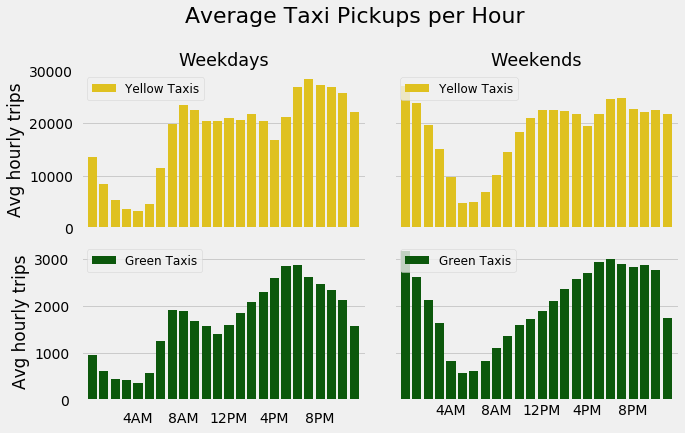

In [32]:
hours = np.arange(0, 24)   

xmin = -1
xmax = 24
ymin = 0.

c_ends = (52.*2)   # Numbers to get the average number of pickups per hour as opposed to the sum
c_days = (52.*5)   # Numbers to get the average number of pickups per hour as opposed to the sum

space = 0.1   # Sets the amount of empty space in between subplots

#Setting up axes limits for plots
ymax_yellow = 1.05*np.max(np.array([np.float(yellow_2014_cleaned_weekdays_binned_Pandas['count'].max()/c_days), np.float(yellow_2014_cleaned_weekends_binned_Pandas['count'].max()/c_ends)]))
ymax_green = 1.05*np.max(np.array([np.float(green_2014_cleaned_weekdays_binned_Pandas['count'].max()/c_days), np.float(green_2014_cleaned_weekends_binned_Pandas['count'].max()/c_ends)]))


# Placing tick marks on x-axis
xticks = np.arange(4, 24, 4)
xtimes = ['4AM', '8AM', '12PM', '4PM',  '8PM']

# Setting font sizes for plot titles and labels
f_title = 22
f_label = 12
f_axis = 17
cc = 0.8

plt.style.use('fivethirtyeight')  # I like fivethirtyeight style!


plt.figure(figsize = (10,6))
plt.suptitle('Average Taxi Pickups per Hour', fontsize = f_title)
plt.subplots_adjust(left = 0.12, hspace=0.1, wspace=space, top = 0.83)

ax1 = plt.subplot(221)
plt.title('Weekdays', fontsize = cc*f_title)
sns.barplot(hours,yellow_2014_cleaned_weekdays_binned_Pandas['count']/c_days, color = 'gold', label = 'Yellow Taxis')
plt.setp( ax1.get_xticklabels(), visible=False)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax_yellow)
plt.xticks(xticks, xtimes )
plt.ylabel('Avg hourly trips', fontsize = f_axis)
plt.legend(loc = 'upper left', fontsize = f_label)
ax1.tick_params(pad = 8)    # Padding tick marks so they align perfectly with tick mark from plots on the bottom and aren't too close to plot


ax2 = plt.subplot(222)
plt.title('Weekends', fontsize = cc*f_title)
sns.barplot(hours,yellow_2014_cleaned_weekends_binned_Pandas['count']/c_ends, color = 'gold', label = 'Yellow Taxis')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax_yellow)
plt.xticks(xticks, xtimes )
plt.legend(loc = 'upper left', fontsize = f_label)
plt.setp( ax2.get_xticklabels(), visible=False)
plt.setp( ax2.get_yticklabels(), visible=False)
plt.ylabel('')


ax3 = plt.subplot(223)
sns.barplot(hours,green_2014_cleaned_weekdays_binned_Pandas['count']/c_days, color = 'darkgreen', label = 'Green Taxis')
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax_green)
plt.xticks(xticks, xtimes )
plt.legend(loc = 'upper left', fontsize = f_label)
plt.ylabel('Avg hourly trips', fontsize = f_axis)
ax3.tick_params(pad = 12) # Padding tick marks so they align perfectly with tick mark from plots on the top and aren't too close to plot

ax4 = plt.subplot(224)
sns.barplot(hours,green_2014_cleaned_weekends_binned_Pandas['count']/c_ends, color = 'darkgreen', label = 'Green Taxis')
plt.setp( ax4.get_yticklabels(), visible=False)
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax_green)
##plt.yticks(yticks_green)
plt.xticks(xticks, xtimes )
plt.legend(loc = 'upper left', fontsize = f_label)
plt.ylabel('')

plt.savefig('Final2.png', dpi = 1000)


